In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler

## Genereta Data with Anomaly

In [2]:
from sklearn.datasets.samples_generator import make_blobs
np.random.seed(42)
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)

# Add two anomalies
X[0,:] = np.array([[-5,-5]])
X[1,:] = np.array([[8,8]])

y[0] = 3
y[1] = 3

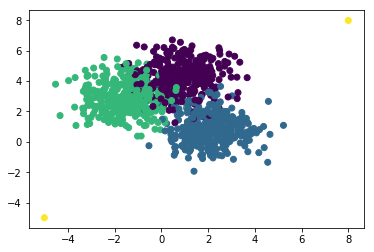

In [3]:
plt.scatter(X[:,0], X[:,1], c = y)

In [4]:
X.shape

(1000, 2)

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

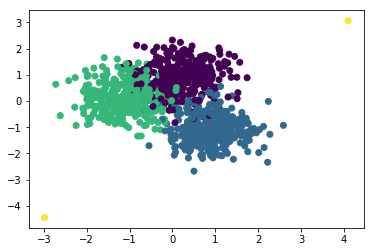

In [6]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], c = y)

## Build Autoencoder with Keras

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

nb_epoch = 10
batch_size = 128
learning_rate = 1e-7

input_dim = X_scaled.shape[1] 
encoding_dim = 1

model = Sequential()
model.add(Dense(encoding_dim, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(Dense(input_dim))
model.add(Activation('relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [8]:
model.compile(metrics=['accuracy'],loss='mean_squared_error', optimizer='adam')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
# Train x = X_scaled with y = X_scaled
history = model.fit(X_scaled, X_scaled, epochs=nb_epoch, batch_size=batch_size, shuffle=True).history

Epoch 1/10
1000/1000 [==============================] - 0s 142us/step - loss: 0.9251 - acc: 0.4040
Epoch 2/10
1000/1000 [==============================] - 0s 12us/step - loss: 0.9208 - acc: 0.4040
Epoch 3/10
1000/1000 [==============================] - 0s 9us/step - loss: 0.9165 - acc: 0.4040
Epoch 4/10
1000/1000 [==============================] - 0s 10us/step - loss: 0.9122 - acc: 0.4040
Epoch 5/10
1000/1000 [==============================] - 0s 9us/step - loss: 0.9078 - acc: 0.4040
Epoch 6/10
1000/1000 [==============================] - 0s 10us/step - loss: 0.9033 - acc: 0.4040
Epoch 7/10
1000/1000 [==============================] - 0s 10us/step - loss: 0.8985 - acc: 0.4040
Epoch 8/10
1000/1000 [==============================] - 0s 9us/step - loss: 0.8938 - acc: 0.4040
Epoch 9/10
1000/1000 [==============================] - 0s 11us/step - loss: 0.8890 - acc: 0.4040
Epoch 10/10
1000/1000 [==============================] - 0s 10us/step - loss: 0.8841 - acc: 0.4040


In [10]:
X_predictions = model.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y})
error_df.describe()

,Reconstruction_error,True_class
count,1000.000000,1000.000000
mean,0.881538,1.003000
std,0.809515,0.820771
min,0.000547,0.000000
25%,0.357309,0.000000
50%,0.702199,1.000000
75%,1.237218,2.000000
max,14.333157,3.000000


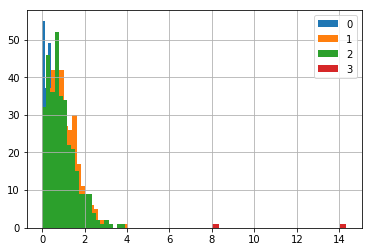

In [11]:
for i in range(4):
    error_df[error_df['True_class'] == i]['Reconstruction_error'].hist(bins = 20, label = i)
plt.legend()

# Functionalize the code

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation


def anomalyDetector(nb_epoch = 10, batch_size = 128, learning_rate = 1e-7, encoding_dim = 1, verbose = 0):

    input_dim = X_scaled.shape[1] 
    encoding_dim = 1

    model = Sequential()
    model.add(Dense(encoding_dim, input_shape=(input_dim,)))
    model.add(Activation('relu'))
    model.add(Dense(input_dim))
    model.add(Activation('relu'))

    model.compile(metrics=['accuracy'],loss='mean_squared_error', optimizer='adam')

    # Train x = X_scaled with y = X_scaled
    history = model.fit(X_scaled, X_scaled, epochs=nb_epoch, 
                        batch_size=batch_size, shuffle=True, verbose = verbose).history
    # Reconstruction_error
    mse = np.mean(np.power(X_scaled - model.predict(X_scaled), 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse,'True_class': y})
    return error_df

def plot_reconstruction_error(error_df):
    # Plot the histogram of Reconstruction_error
    for i in range(4):
        error_df[error_df['True_class'] == i]['Reconstruction_error'].hist(bins = 20, label = i)
    plt.legend()

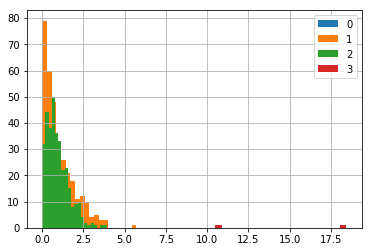

In [13]:
error_df = anomalyDetector(encoding_dim = 1)
plot_reconstruction_error(error_df)

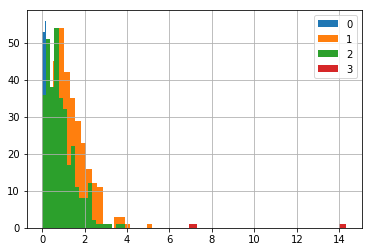

In [14]:
error_df = anomalyDetector(encoding_dim = 2)
plot_reconstruction_error(error_df)

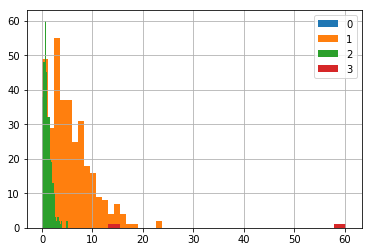

In [15]:
error_df = anomalyDetector(encoding_dim = 3)
plot_reconstruction_error(error_df)

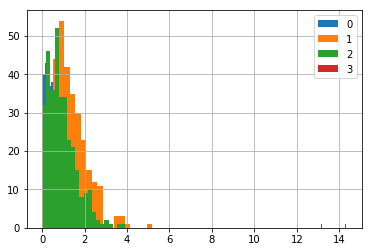

In [16]:
error_df = anomalyDetector(encoding_dim = 4)
plot_reconstruction_error(error_df)

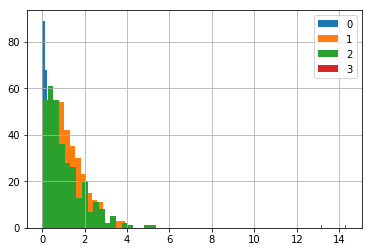

In [17]:
error_df = anomalyDetector(encoding_dim = 5)
plot_reconstruction_error(error_df)

In [18]:
## Deneme

In [19]:
# For custom metrics
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', mean_pred])